# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train_data_v2.json', 'r'))
val_data = json.load(open('NER_val_data_v2.json', 'r'))
test_data = json.load(open('NER_test_data_v2.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# GRU Implementation

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4177, Accuracy: 0.8962, F1: 0.3655
Validation: Loss: 0.3229, Accuracy: 0.9149, F1: 0.4260
Epoch 2/10
Training: Loss: 0.2865, Accuracy: 0.9206, F1: 0.5211
Validation: Loss: 0.2922, Accuracy: 0.9231, F1: 0.5229
Epoch 3/10
Training: Loss: 0.2456, Accuracy: 0.9300, F1: 0.5932
Validation: Loss: 0.2873, Accuracy: 0.9231, F1: 0.5370
Epoch 4/10
Training: Loss: 0.2163, Accuracy: 0.9369, F1: 0.6372
Validation: Loss: 0.2927, Accuracy: 0.9235, F1: 0.5503
Epoch 5/10
Training: Loss: 0.1930, Accuracy: 0.9424, F1: 0.6762
Validation: Loss: 0.3067, Accuracy: 0.9221, F1: 0.5435
Epoch 6/10
Training: Loss: 0.1727, Accuracy: 0.9477, F1: 0.7068
Validation: Loss: 0.3147, Accuracy: 0.9213, F1: 0.5397
Epoch 7/10
Training: Loss: 0.1563, Accuracy: 0.9524, F1: 0.7320
Validation: Loss: 0.3278, Accuracy: 0.9222, F1: 0.5344
Epoch 8/10
Training: Loss: 0.1417, Accuracy: 0.9565, F1: 0.7576
Validation: Loss: 0.3423, Accuracy: 0.9202, F1: 0.5327
Epoch 9/10
Training: Loss: 0.1300, Accuracy: 0.9

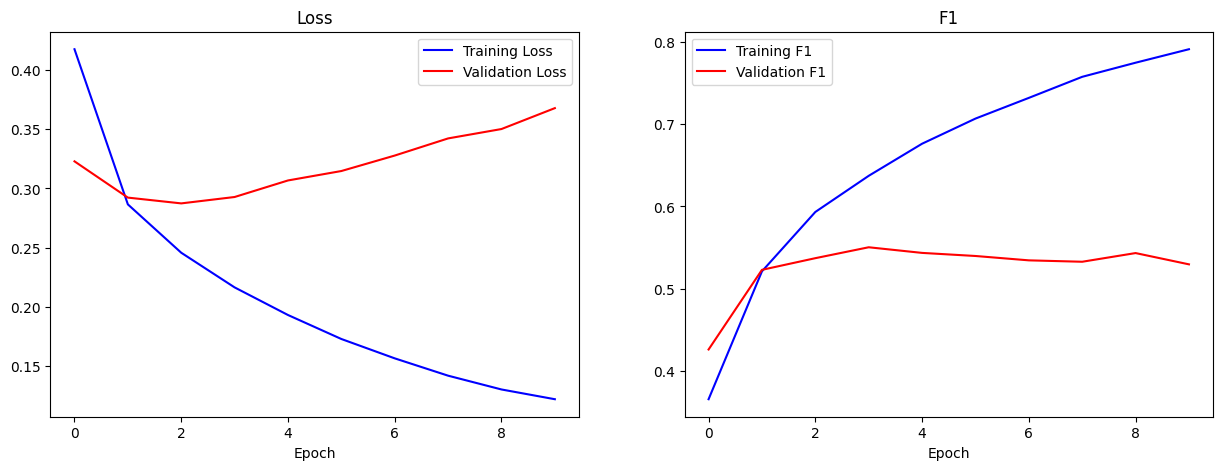

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(gru_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
torch.save(gru_word2vec_model, "t1_model3_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model3_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03805530942762754, 1: 0.04431818181818181, 2: 0.06199930337861372, 3: 0.01873536299765808, 4: 0.022214854111405835, 5: 0.05393665158371041, 6: 0.05017921146953405, 7: 0.1012064343163539, 8: 0.13871951219512194, 9: 0.22669491525423727, 10: 0.14191852825229961, 11: 0.0937950937950938, 12: 0.0905050505050505, 13: 0.08860759493670887, 14: 0.04621465491030708, 15: 0.053588516746411484, 16: 0.1487946799667498, 17: 0.125, 18: 0.1764705882352941, 19: 0.11948051948051948, 20: 0.0661764705882353, 21: 0.24999999999999997, 22: 0.039999999999999994, 23: 0.13095238095238096, 24: 0.13333333333333333, 25: 0.36363636363636365, 26: 0.10169491525423728}
Labelwise Accuracy Scores:
{0: 0.9790968681718863, 1: 0.32231404958677684, 2: 0.5174418604651163, 3: 0.1509433962264151, 4: 0.2161290322580645, 5: 0.5398550724637681, 6: 0.4307692307692308, 7: 0.6801801801801802, 8: 0.7127937336814621, 9: 0.8294573643410853, 10: 0.7414187643020596, 11: 0.7303370786516854, 12: 0.6871165644171779,

# For GloVe Embeddings

In [51]:
input_size, hidden_size, output_size = 300, 64, 27

gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(gru_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [52]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5528, Accuracy: 0.8678, F1: 0.1781
Validation: Loss: 0.4854, Accuracy: 0.8775, F1: 0.2740
Epoch 2/10
Training: Loss: 0.4528, Accuracy: 0.8851, F1: 0.2912
Validation: Loss: 0.4575, Accuracy: 0.8833, F1: 0.3254
Epoch 3/10
Training: Loss: 0.4268, Accuracy: 0.8900, F1: 0.3383
Validation: Loss: 0.4430, Accuracy: 0.8869, F1: 0.3580
Epoch 4/10
Training: Loss: 0.4094, Accuracy: 0.8931, F1: 0.3644
Validation: Loss: 0.4362, Accuracy: 0.8878, F1: 0.3727
Epoch 5/10
Training: Loss: 0.3960, Accuracy: 0.8957, F1: 0.3819
Validation: Loss: 0.4321, Accuracy: 0.8892, F1: 0.3763
Epoch 6/10
Training: Loss: 0.3840, Accuracy: 0.8979, F1: 0.3976
Validation: Loss: 0.4309, Accuracy: 0.8891, F1: 0.3788
Epoch 7/10
Training: Loss: 0.3734, Accuracy: 0.9007, F1: 0.4121
Validation: Loss: 0.4308, Accuracy: 0.8894, F1: 0.3813
Epoch 8/10
Training: Loss: 0.3634, Accuracy: 0.9028, F1: 0.4242
Validation: Loss: 0.4323, Accuracy: 0.8895, F1: 0.3884
Epoch 9/10
Training: Loss: 0.3537, Accuracy: 0.9

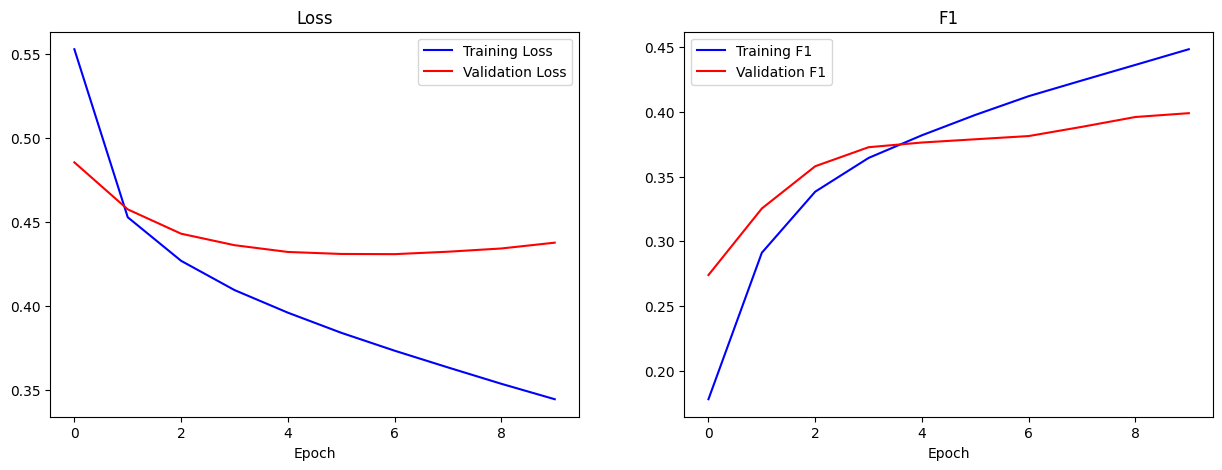

In [53]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [18]:
# fine_tune(gru_glove_model, glove, val_data, criterion, optimizer, device='cuda', epochs=2)

In [54]:
test_accuracy, test_f1 = test(gru_glove_model, glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036497888563210366, 1: 0.026888604353393086, 2: 0.041416165664662656, 3: 0.0, 4: 0.011406096361848575, 5: 0.021084337349397592, 6: 0.03231939163498099, 7: 0.12834718374884582, 8: 0.10108864696734059, 9: 0.08915211970074813, 10: 0.06095791001451379, 11: 0.04641975308641974, 12: 0.059482758620689656, 13: 0.026455026455026454, 14: 0.05625879043600563, 15: 0.05759594037424674, 16: 0.1267454350161117, 17: 0.06666666666666667, 18: 0.02777777777777778, 19: 0.06769230769230769, 20: 0.03766358123204597, 21: 0.0, 22: 0.1212121212121212, 23: 0.14444444444444443, 24: 0.0, 25: 0.0, 26: 0.02}
Labelwise Accuracy Scores:
{0: 0.9713037144938091, 1: 0.17355371900826447, 2: 0.45058139534883723, 3: 0.0, 4: 0.0935483870967742, 5: 0.2028985507246377, 6: 0.3487179487179487, 7: 0.6261261261261262, 8: 0.6788511749347258, 9: 0.5542635658914729, 10: 0.5766590389016019, 11: 0.2640449438202247, 12: 0.4233128834355828, 13: 0.08620689655172414, 14: 0.3389830508474576, 15: 0.760469011725293

In [20]:
torch.save(gru_glove_model, "t1_model3_glove.pt")

In [21]:
test_accuracy, test_f1 = test("t1_model3_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.0363354504618721, 1: 0.03296703296703297, 2: 0.049429657794676805, 3: 0.001461454146876142, 4: 0.018518518518518514, 5: 0.01906158357771261, 6: 0.029411764705882353, 7: 0.083645443196005, 8: 0.06404072883172562, 9: 0.0785296574770259, 10: 0.060029282576866766, 11: 0.04110671936758893, 12: 0.0818260120585702, 13: 0.06857142857142857, 14: 0.03896103896103896, 15: 0.04175609756097561, 16: 0.09795689896445564, 17: 0.06666666666666667, 18: 0.10714285714285714, 19: 0.09577464788732394, 20: 0.04002501563477174, 21: 0.0, 22: 0.1212121212121212, 23: 0.22282608695652176, 24: 0.1, 25: 0.0, 26: 0.028301886792452827}
Labelwise Accuracy Scores:
{0: 0.9628186453022578, 1: 0.2727272727272727, 2: 0.5290697674418605, 3: 0.012578616352201259, 4: 0.16129032258064516, 5: 0.23550724637681159, 6: 0.3076923076923077, 7: 0.6036036036036037, 8: 0.6240208877284595, 9: 0.5465116279069767, 10: 0.562929061784897, 11: 0.29213483146067415, 12: 0.5828220858895705, 13: 0.20689655172413793, 14

# For FastText Embeddings

In [29]:
input_size, hidden_size, output_size = 300, 128, 27
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_fasttext_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [30]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4290, Accuracy: 0.8953, F1: 0.3336
Validation: Loss: 0.3093, Accuracy: 0.9180, F1: 0.4232
Epoch 2/10
Training: Loss: 0.2783, Accuracy: 0.9235, F1: 0.4782
Validation: Loss: 0.2778, Accuracy: 0.9245, F1: 0.4906
Epoch 3/10
Training: Loss: 0.2402, Accuracy: 0.9315, F1: 0.5522
Validation: Loss: 0.2646, Accuracy: 0.9274, F1: 0.5327
Epoch 4/10
Training: Loss: 0.2136, Accuracy: 0.9378, F1: 0.6076
Validation: Loss: 0.2627, Accuracy: 0.9286, F1: 0.5448
Epoch 5/10
Training: Loss: 0.1921, Accuracy: 0.9435, F1: 0.6472
Validation: Loss: 0.2599, Accuracy: 0.9302, F1: 0.5530
Epoch 6/10
Training: Loss: 0.1747, Accuracy: 0.9479, F1: 0.6778
Validation: Loss: 0.2614, Accuracy: 0.9317, F1: 0.5601
Epoch 7/10
Training: Loss: 0.1574, Accuracy: 0.9529, F1: 0.7094
Validation: Loss: 0.2700, Accuracy: 0.9317, F1: 0.5637
Epoch 8/10
Training: Loss: 0.1424, Accuracy: 0.9573, F1: 0.7366
Validation: Loss: 0.2777, Accuracy: 0.9319, F1: 0.5699
Epoch 9/10
Training: Loss: 0.1320, Accuracy: 0.9

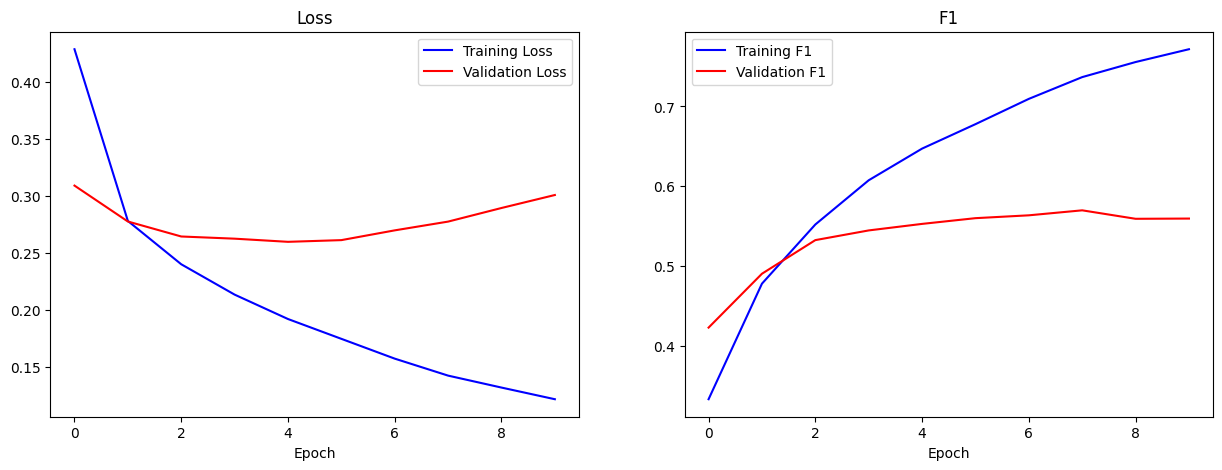

In [31]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [35]:
fine_tune(gru_fasttext_model, fasttext, val_data, criterion, optimizer, device='cuda', epochs=2)

Epoch 1/2
FineTuning: Loss: 0.2941, Accuracy: 0.9273, F1: 0.5571
Epoch 2/2
FineTuning: Loss: 0.1921, Accuracy: 0.9467, F1: 0.6528


In [36]:
test_accuracy, test_f1 = test(gru_fasttext_model, fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.039668802438084044, 1: 0.0389363722697056, 2: 0.07652280379553106, 3: 0.03482587064676617, 4: 0.05202863961813843, 5: 0.04526166902404526, 6: 0.061633281972265024, 7: 0.09877384196185286, 8: 0.15198863636363638, 9: 0.18589211618257262, 10: 0.1552567237163814, 11: 0.08626198083067092, 12: 0.09645061728395062, 13: 0.05921052631578948, 14: 0.04743935309973046, 15: 0.06832831972496776, 16: 0.2948073701842546, 17: 0.15384615384615383, 18: 0.15625, 19: 0.07467532467532467, 20: 0.06651884700665188, 21: 0.1904761904761905, 22: 0.0, 23: 0.18526315789473685, 24: 0.13636363636363635, 25: 0.15, 26: 0.08225108225108224}
Labelwise Accuracy Scores:
{0: 0.9835761107064822, 1: 0.33884297520661155, 2: 0.7267441860465116, 3: 0.2641509433962264, 4: 0.35161290322580646, 5: 0.463768115942029, 6: 0.5128205128205128, 7: 0.6531531531531531, 8: 0.8381201044386423, 9: 0.8682170542635659, 10: 0.8718535469107551, 11: 0.7584269662921348, 12: 0.7668711656441718, 13: 0.3103448275862069, 14:

In [37]:
torch.save(gru_fasttext_model, "t1_model3_fasttext.pt")

In [38]:
test_accuracy, test_f1 = test("t1_model3_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.039668802438084044, 1: 0.0389363722697056, 2: 0.07652280379553106, 3: 0.03482587064676617, 4: 0.05202863961813843, 5: 0.04526166902404526, 6: 0.061633281972265024, 7: 0.09877384196185286, 8: 0.15198863636363638, 9: 0.18589211618257262, 10: 0.1552567237163814, 11: 0.08626198083067092, 12: 0.09645061728395062, 13: 0.05921052631578948, 14: 0.04743935309973046, 15: 0.06832831972496776, 16: 0.2948073701842546, 17: 0.15384615384615383, 18: 0.15625, 19: 0.07467532467532467, 20: 0.06651884700665188, 21: 0.1904761904761905, 22: 0.0, 23: 0.18526315789473685, 24: 0.13636363636363635, 25: 0.15, 26: 0.08225108225108224}
Labelwise Accuracy Scores:
{0: 0.9835761107064822, 1: 0.33884297520661155, 2: 0.7267441860465116, 3: 0.2641509433962264, 4: 0.35161290322580646, 5: 0.463768115942029, 6: 0.5128205128205128, 7: 0.6531531531531531, 8: 0.8381201044386423, 9: 0.8682170542635659, 10: 0.8718535469107551, 11: 0.7584269662921348, 12: 0.7668711656441718, 13: 0.3103448275862069, 14: